# Customer Segmentation
Businesses often prefer to segment their customers so that they may develop unique marketing strategies for each group of customers.  This project aims to determine the types of customers (target customers) who can easily convert into loyal customers so that the marketing team can make an informed decision about their approach. I Use the customer segmentation dataset on Kaggle, which contains the basic information about the customers - the customers' age, gender, annual income, and spending score. For clustering I will use the following algorithms K-Means, Hierarchical clustering - AHC and GaussianMixture.

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# 2. Loading dataset

In [2]:
df_custumers = pd.read_csv('Mall_Customers.csv')
df_custumers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Print DataFrame information
df_custumers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
# Inspect missing values in the datase
df_custumers.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
# Check if we have duplicate rows
df_custumers[df_custumers.duplicated(subset = df_custumers.columns, keep = False)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)


In [6]:
# Print summary statistics. 
df_custumers.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


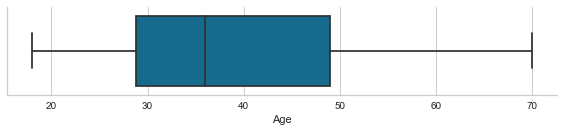

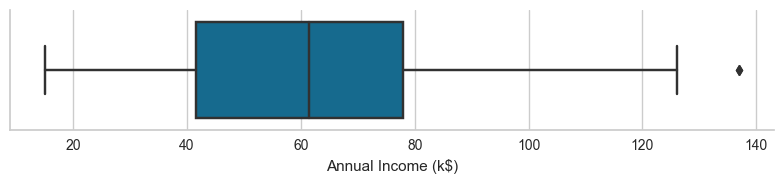

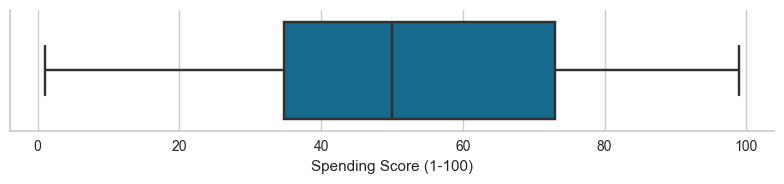

In [7]:
# Ploting the distribution of numerical data 
for col in df_custumers.select_dtypes(include= ['int64']).drop(columns = ['CustomerID'], axis =1):
    sns.catplot(x =col, data = df_custumers, kind = 'box', height = 2, aspect= 4)
    plt.show()                                           

# 3. Scaling and econding the data

* The numerical data have very different scales. In order to cluster this data effectively, you'll need to standardize these features first. Also we need to encode the categorical data. We uses OneHotEncoder for categorical variables and StandardScaler for numerical variables. 

In [8]:
#scaling numeric data
scaler = StandardScaler()
numerical_feautures = scaler.fit_transform(df_custumers.select_dtypes(include = ['int64']))
numerical_feautures[:5]

array([[-1.7234121 , -1.42456879, -1.73899919, -0.43480148],
       [-1.70609137, -1.28103541, -1.73899919,  1.19570407],
       [-1.68877065, -1.3528021 , -1.70082976, -1.71591298],
       [-1.67144992, -1.13750203, -1.70082976,  1.04041783],
       [-1.6541292 , -0.56336851, -1.66266033, -0.39597992]])

In [9]:
#enconding categorical data
OHE = OneHotEncoder(drop ='first')
categorical_feautures = OHE.fit_transform(df_custumers.select_dtypes(include = ['object']))
categ_feautures = categorical_feautures.toarray()
categ_feautures[:5]

array([[1.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [10]:
#creating a array with the scaled numerical data and the encoded categorical data
feautures_scaled = np.hstack((numerical_feautures, categ_feautures))
feautures_scaled[:5]

array([[-1.7234121 , -1.42456879, -1.73899919, -0.43480148,  1.        ],
       [-1.70609137, -1.28103541, -1.73899919,  1.19570407,  1.        ],
       [-1.68877065, -1.3528021 , -1.70082976, -1.71591298,  0.        ],
       [-1.67144992, -1.13750203, -1.70082976,  1.04041783,  0.        ],
       [-1.6541292 , -0.56336851, -1.66266033, -0.39597992,  0.        ]])

# 4. Determine de optimal number of clusters for K-Means algorithm

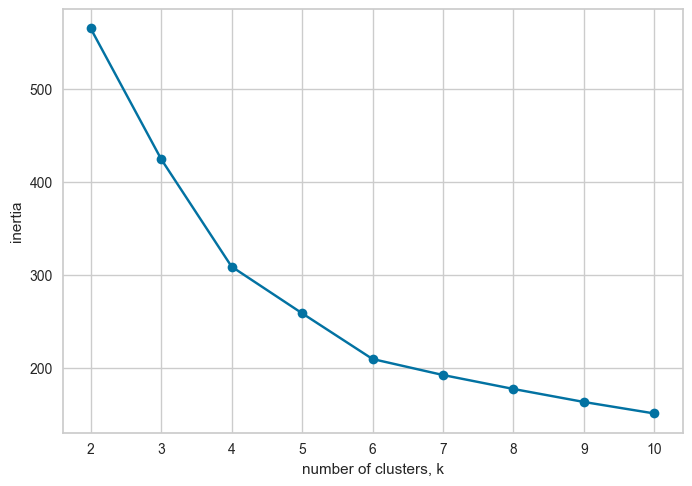

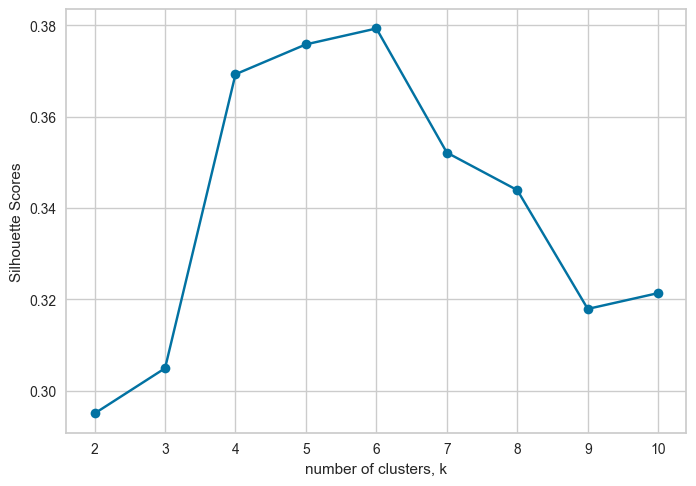

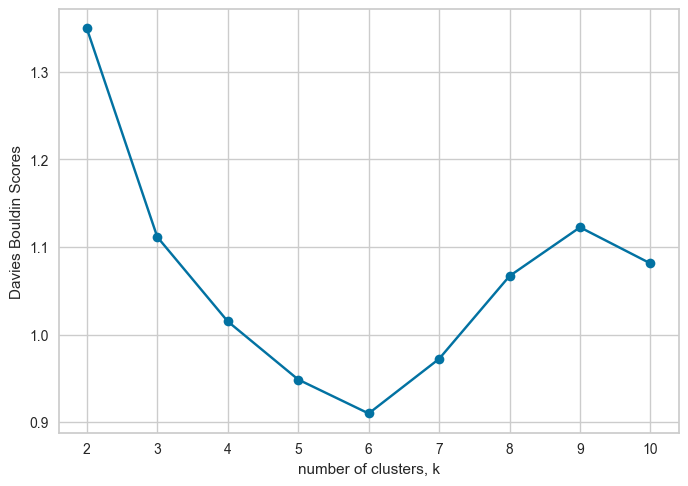

In [11]:
# We use first the elbow method
ks = range(2, 11)
inertias = []
silhouette_scores = []
davies_b_scores = []

for k in ks:
    # Create a KMeans instance with k clusters: model
       # init: we use "k-means++" to ensure centroids are initialized with some distance between them. 
       # n_init: increase the number of initializations to ensure we find a stable solution.
       # max_iter: increase the number of iterations per initialization to ensure that k-means will converge.
    model = KMeans(n_clusters=k, init="k-means++", n_init=50, max_iter=500, random_state=42)
    
    # Fit model to samples
    model.fit(feautures_scaled)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)  # this is SSE 
    silhouette_scores.append(silhouette_score(feautures_scaled, model.labels_))
    davies_b_scores.append(davies_bouldin_score(feautures_scaled, model.labels_))
    
# Plot ks vs inertias
fig, ax = plt.subplots()
ax.plot(ks, inertias, '-o')
ax.set_xlabel('number of clusters, k')
ax.set_ylabel('inertia')
ax.set_xticks(ks)
plt.show()

# Plot ks vs silhouette_scores
fig, ax = plt.subplots()
ax.plot(ks, silhouette_scores, '-o')
ax.set_xlabel('number of clusters, k')
ax.set_ylabel('Silhouette Scores')
ax.set_xticks(ks)
plt.show()

# Plot ks vs davies_b_scores
fig, ax = plt.subplots()
ax.plot(ks, davies_b_scores, '-o')
ax.set_xlabel('number of clusters, k')
ax.set_ylabel('Davies Bouldin Scores')
ax.set_xticks(ks)
plt.show()

* The graphs above indicate that 6 is the elbow point

 Silhouette score for 2 custers is 0.2950433872825704


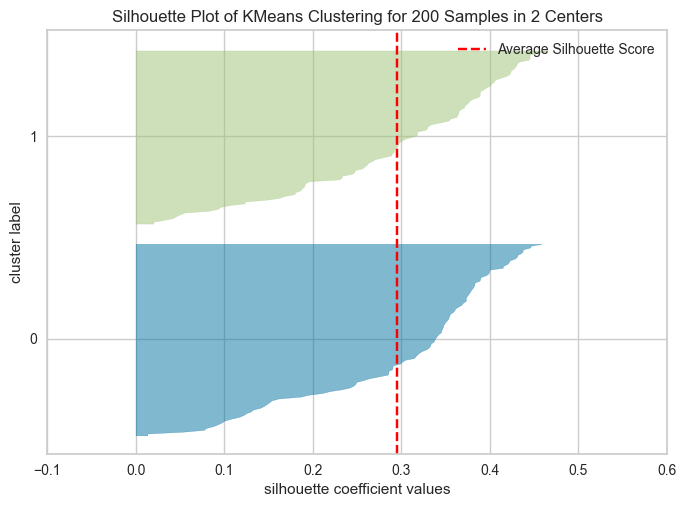

 Silhouette score for 3 custers is 0.3049386110148458


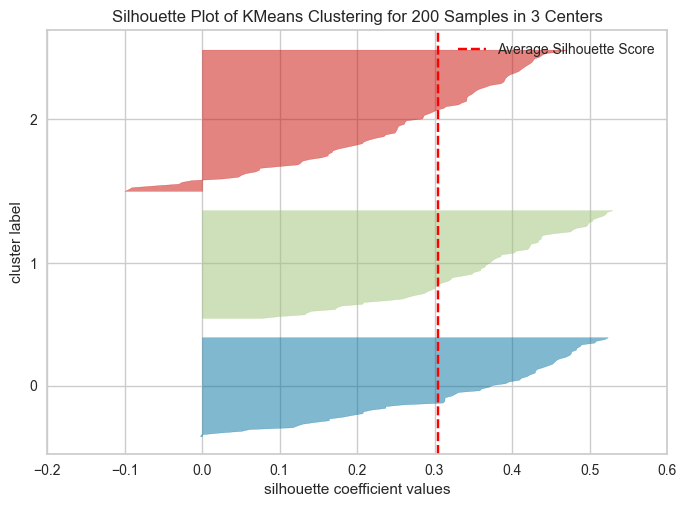

 Silhouette score for 4 custers is 0.3692779308223213


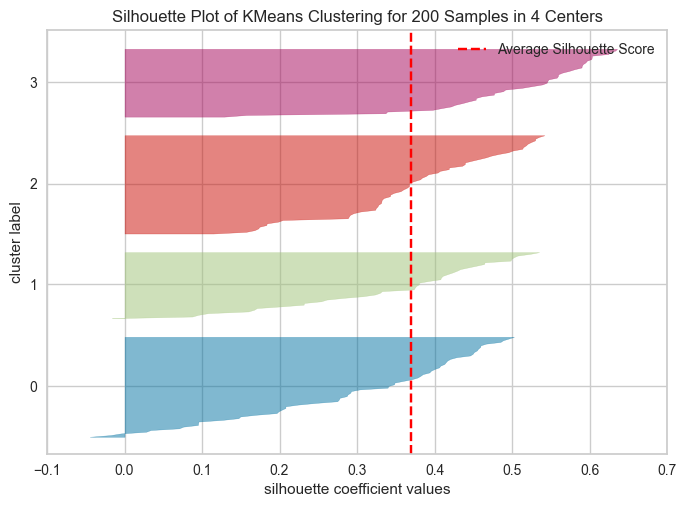

 Silhouette score for 5 custers is 0.37581650891555796


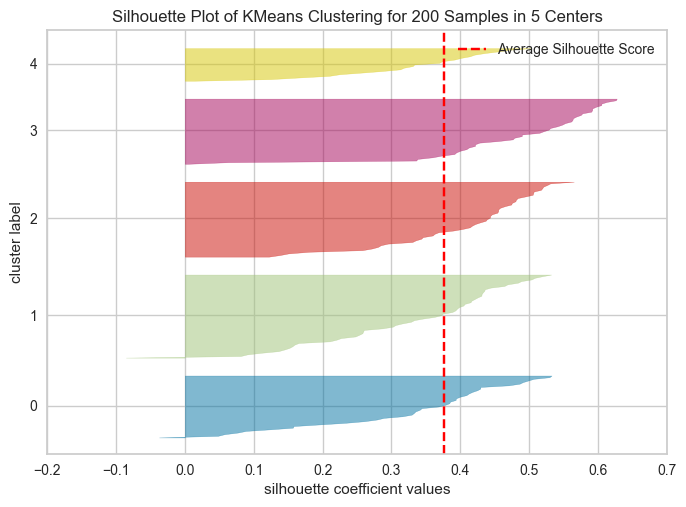

 Silhouette score for 6 custers is 0.37929662450233764


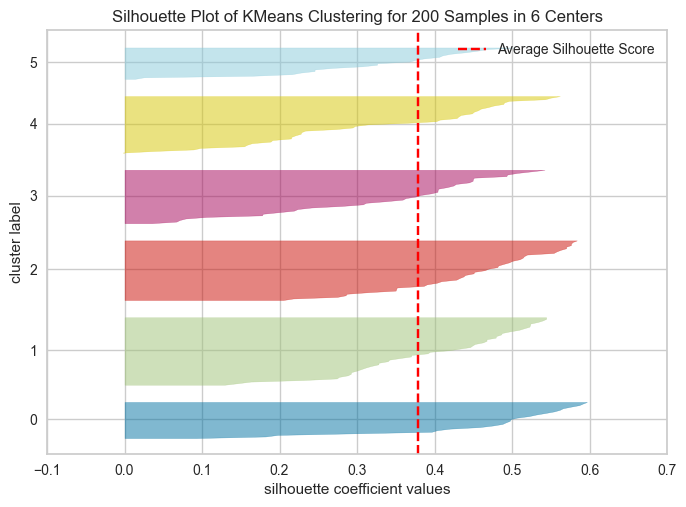

 Silhouette score for 7 custers is 0.3521272689868175


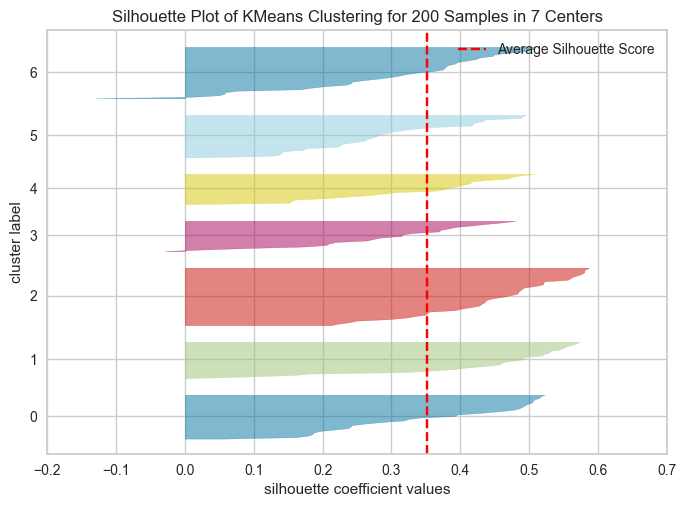

In [12]:
# We use now the silhouette_visualizer method 
ks = range(2, 8)
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init="k-means++", n_init=50, max_iter=500, random_state=42)
    
    # Fit model to samples
    model.fit(feautures_scaled)
    print(f' Silhouette score for {k} custers is {silhouette_score(feautures_scaled, model.labels_)}')

    sil_visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    sil_visualizer.fit(feautures_scaled)
    sil_visualizer.show()

* The graphs above confirm that 6 is the best choice for k

# 5. Training the final clustering K-Means model

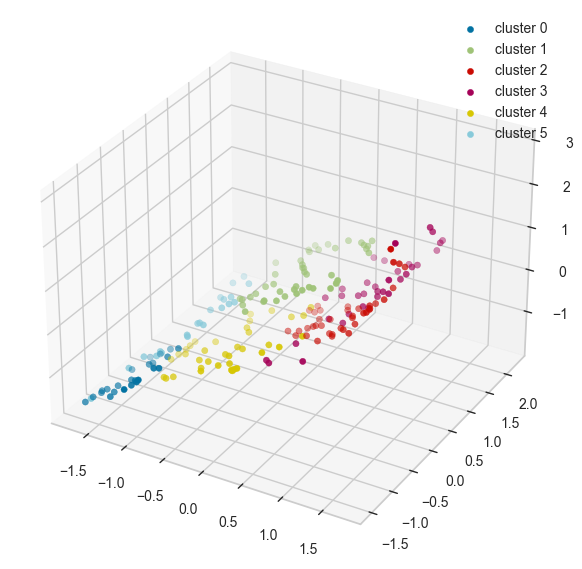

In [13]:
# Create a KMeans instance with k clusters:
model_final = KMeans(n_clusters=6, init="k-means++", n_init=50, max_iter=500, random_state=42)
# Fit model to samples
labels = model_final.fit_predict(feautures_scaled)
# plot clusters
fig = plt.figure()
ax = Axes3D(fig)

for cluster_label in np.unique(labels):
    idx_label = np.where(labels==cluster_label)
    pc1 = feautures_scaled[idx_label,0]
    pc2 = feautures_scaled[idx_label,1]
    pc3 = feautures_scaled[idx_label,2]
    ax.scatter(pc1, pc2, pc3, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

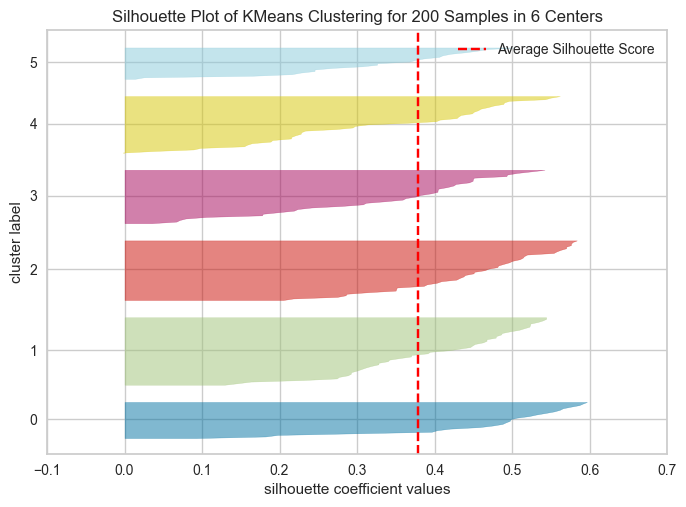

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [14]:
# Evaluation and visualization of final clustered datapoints
sil_visualizer = SilhouetteVisualizer(model_final, colors='yellowbrick')
sil_visualizer.fit(feautures_scaled)
sil_visualizer.show()

In [15]:
# Evaluation of final clustered datapoint using metrics
print(f' SSE for K_Means: {model_final.inertia_} \n',
      f'Davies Bouldin score for K_Means: {davies_bouldin_score(feautures_scaled, model_final.labels_)}\n',
      f'Silhouette score  for K_Means: {silhouette_score(feautures_scaled, model_final.labels_)}')

 SSE for K_Means: 209.2530132155363 
 Davies Bouldin score for K_Means: 0.9098925134333017
 Silhouette score  for K_Means: 0.37929662450233764


# 6. Dimensionality reduction - using PCA and t_NSE algorithms

**Dimensionality reduction with PCA**

In [16]:
# We will make first a decorerarisation by creating and fiting the a PCA model.
model_pca = PCA()
pca_features = model_pca.fit_transform(feautures_scaled)
pca_features.shape

(200, 5)

Text(0, 0.5, 'variance')

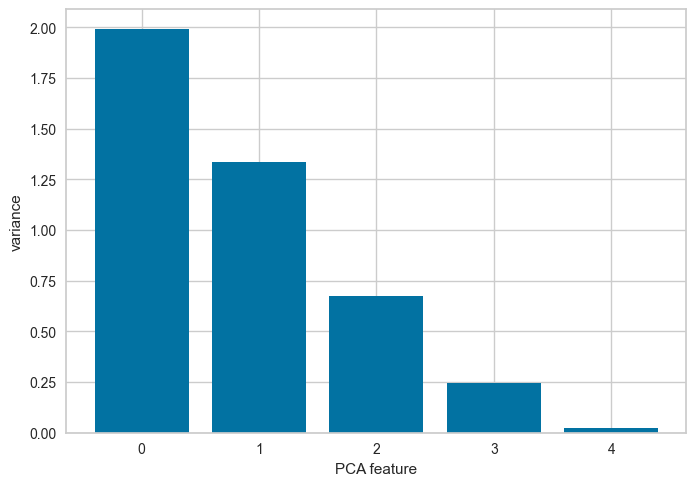

In [17]:
# Now use PCA for dimensionality reduction
features = range(model_pca.n_components_)
plt.bar(features, model_pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')

* We see that 3 is a reasonable choice for the "intrinsic dimension" and we will keep only the first 3 PCA feautures.

In [18]:
# Create a PCA model with 3 components:
final_pca = PCA(n_components=3)

# Fit the PCA instance to the scaled samples
final_pca.fit(feautures_scaled)

# Transform the scaled samples: pca_features
final_pca_features = final_pca.transform(feautures_scaled)
# Print the shape of pca_features
print(pca_features.shape)

(200, 5)


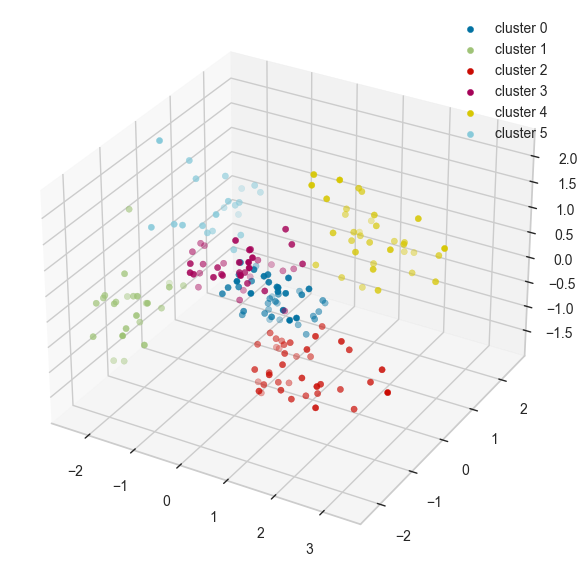

In [19]:
# Create a KMeans instance with k clusters
model_final2 = KMeans(n_clusters=6, init="k-means++", n_init=50, max_iter=500, random_state=42)
# Fit model to samples
labels2 = model_final2.fit_predict(final_pca_features)

# plot clusters
fig = plt.figure()
ax = Axes3D(fig)

for cluster_label in np.unique(labels2):
    idx_label = np.where(labels2==cluster_label)
    pc1 = final_pca_features[idx_label,0]
    pc2 = final_pca_features[idx_label,1]
    pc3 = final_pca_features[idx_label,2]
    ax.scatter(pc1, pc2, pc3, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

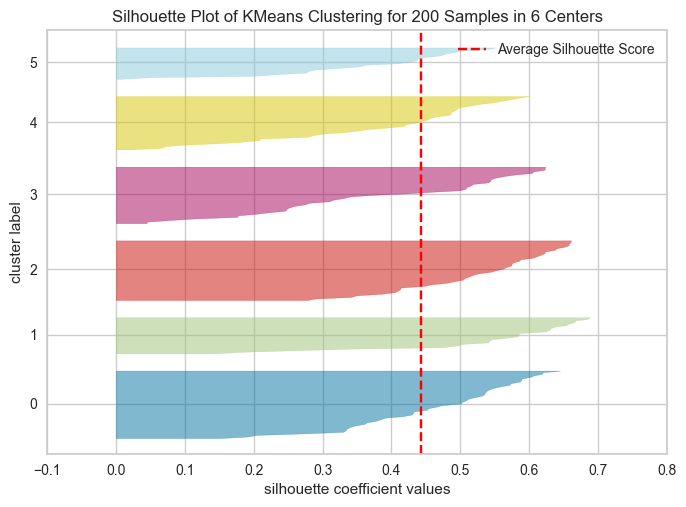

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
# Evaluation and visualization of final clustered datapoints
sil_visualizer = SilhouetteVisualizer(model_final2, colors='yellowbrick')
sil_visualizer.fit(final_pca_features)
sil_visualizer.show()

In [21]:
print(f' SSE for K_Means after PCA dimension reduction: {model_final2.inertia_}\n',
      f'Davies Bouldin score for K_Means after PCA dimension reduction: {davies_bouldin_score(final_pca_features, model_final2.labels_)}\n',
      f'Silhouette score  for K_Means after PCA dimension reduction: {silhouette_score(final_pca_features, model_final2.labels_)}')

 SSE for K_Means after PCA dimension reduction: 156.80461576408038
 Davies Bouldin score for K_Means after PCA dimension reduction: 0.7657601283698471
 Silhouette score  for K_Means after PCA dimension reduction: 0.4428038889937115


In [22]:
df_results = pd.DataFrame({'Model_name': 'K_Means',
               'Davies_Bouldin_score': davies_bouldin_score(feautures_scaled, model_final.labels_),
               'Silhouette_score': silhouette_score(feautures_scaled, model_final.labels_)},
                index=[0]) 
df_results.loc[1] =['K_Means after PCA', 
                     davies_bouldin_score(final_pca_features, model_final2.labels_), 
                     silhouette_score(final_pca_features, model_final2.labels_)]
df_results.sort_values(by =['Davies_Bouldin_score', 'Silhouette_score']).reset_index(drop =True)

,Model_name,Davies_Bouldin_score,Silhouette_score
0,K_Means after PCA,0.765760,0.442804
1,K_Means,0.909893,0.379297


* We see a slightly improvemnet of the SSE  and silhouette score

**Dimensionality reduction with TSNE**

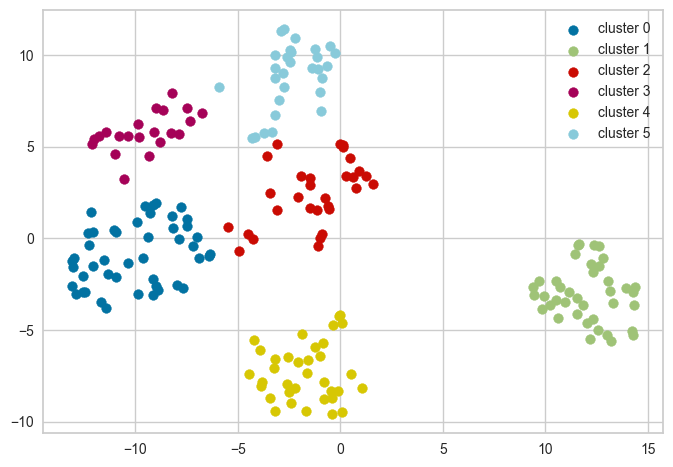

In [23]:
# Create a TSNE instance with 2 components
tsne = TSNE(n_components=2)

# Apply fit_transform to samples: tsne_features
tsne_features_2 = tsne.fit_transform(feautures_scaled)

# Create a KMeans instance with k clusters
model_final3 = KMeans(n_clusters=6, init="k-means++", n_init=50, max_iter=500, random_state=42)
# Fit model to samples
labels3 = model_final3.fit_predict(tsne_features_2)

# Scatter plot, coloring by variety_numbers
for cluster_label in np.unique(labels3):
    idx_label = np.where(labels3 ==cluster_label)
    pc1 = tsne_features_2[idx_label,0]
    pc2 = tsne_features_2[idx_label,1]
    plt.scatter(pc1, pc2, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

In [24]:
print(f' SSE for K_Means after t-SNE2 dimension reduction: {model_final3.inertia_}\n',
      f'Davies Bouldin score for K_Means after t-SNE2 dimension reduction: {davies_bouldin_score(tsne_features_2, model_final3.labels_)}\n',
      f'Silhouette score  for K_Means after t-SNE2 dimension reduction: {silhouette_score(tsne_features_2, model_final3.labels_)}')

 SSE for K_Means after t-SNE2 dimension reduction: 1054.6473388671875
 Davies Bouldin score for K_Means after t-SNE2 dimension reduction: 0.5493986038632238
 Silhouette score  for K_Means after t-SNE2 dimension reduction: 0.6077685952186584


In [25]:
df_results.loc[2] =['K_Means_after_t-SNE2', 
                     davies_bouldin_score(tsne_features_2, model_final3.labels_), 
                     silhouette_score(tsne_features_2, model_final3.labels_)]
df_results.sort_values(by =['Davies_Bouldin_score', 'Silhouette_score']).reset_index(drop =True)

,Model_name,Davies_Bouldin_score,Silhouette_score
0,K_Means_after_t-SNE2,0.549399,0.607769
1,K_Means after PCA,0.765760,0.442804
2,K_Means,0.909893,0.379297


We see a improvemnet of the Davies Bouldin score  and silhouette score.

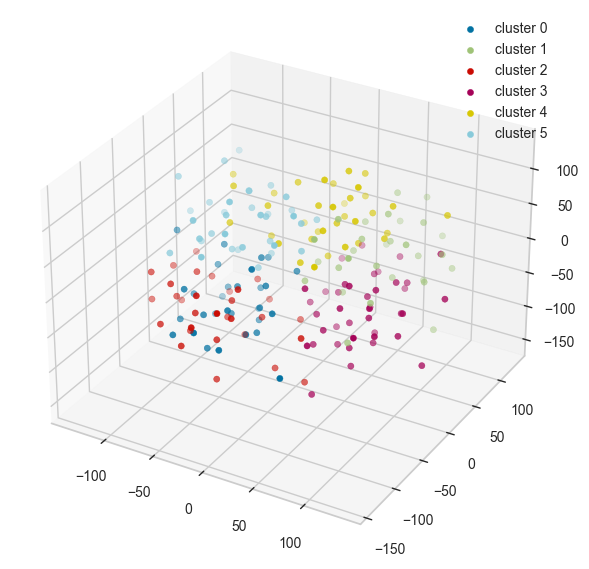

In [26]:
# Create a TSNE instance with 3 components
tsne1 = TSNE(n_components=3)

# Apply fit_transform to samples: tsne_features
tsne_features_3 = tsne1.fit_transform(feautures_scaled)

# Create a KMeans instance with k clusters: model
model_final4 = KMeans(n_clusters=6, init="k-means++", n_init=50, max_iter=500, random_state=42)
# Fit model to samples
labels3 = model_final4.fit_predict(tsne_features_3 )

# plot clusters
fig = plt.figure()
ax = Axes3D(fig)

# Select the tsne features
for cluster_label in np.unique(labels3):
    idx_label = np.where(labels3==cluster_label)
    cp1 = tsne_features_3[idx_label,0]
    cp2 = tsne_features_3[idx_label,1]
    cp3 = tsne_features_3[idx_label,2]
    ax.scatter(cp1, cp2, cp3, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

In [27]:
print(f' SSE for K_Means after t-SNE3 dimension reduction: {model_final4.inertia_}\n',
      f'Davies Bouldin score for K_Means after t-SNE3 dimension reduction: {davies_bouldin_score(tsne_features_3, model_final4.labels_)}\n',
      f'Silhouette score  for K_Means after t-SNE3 dimension reduction: {silhouette_score(tsne_features_3, model_final4.labels_)}')

 SSE for K_Means after t-SNE3 dimension reduction: 717424.5
 Davies Bouldin score for K_Means after t-SNE3 dimension reduction: 1.0157893236159634
 Silhouette score  for K_Means after t-SNE3 dimension reduction: 0.30137044191360474


In [28]:
df_results.loc[3] =['K_Means_after_t-SNE3',  
                     davies_bouldin_score(tsne_features_3, model_final4.labels_), 
                     silhouette_score(tsne_features_3, model_final4.labels_)]
df_results.sort_values(by =['Davies_Bouldin_score', 'Silhouette_score']).reset_index(drop =True)

,Model_name,Davies_Bouldin_score,Silhouette_score
0,K_Means_after_t-SNE2,0.549399,0.607769
1,K_Means after PCA,0.765760,0.442804
2,K_Means,0.909893,0.379297
3,K_Means_after_t-SNE3,1.015789,0.301370


* We don't see any improvement in any scores. The K-means model with using the 2D tsne_features performs best.

# 7. Clustering with Gaussian mixed model

In [29]:
# Creating and fiting the a Gaussian mixed model
gmm_model = GaussianMixture(n_components=6).fit(feautures_scaled)
labels_gmm = gmm_model.predict(feautures_scaled)
np.unique(labels_gmm)

array([0, 1, 2, 3, 4, 5], dtype=int64)

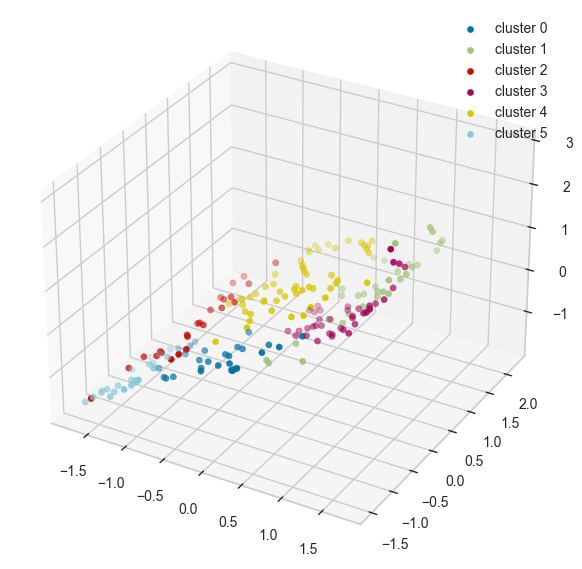

In [30]:
# plot clusters
fig = plt.figure()
ax = Axes3D(fig)

for cluster_label in np.unique(labels_gmm):
    idx_label = np.where(labels_gmm==cluster_label)
    pc1 = feautures_scaled[idx_label,0]
    pc2 = feautures_scaled[idx_label,1]
    pc3 = feautures_scaled[idx_label,2]
    ax.scatter(pc1, pc2, pc3, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

In [31]:
df_results.loc[4] =['GMM',  
                     davies_bouldin_score(tsne_features_3, labels_gmm), 
                     silhouette_score(tsne_features_3, labels_gmm)]
df_results.sort_values(by =['Davies_Bouldin_score', 'Silhouette_score']).reset_index(drop =True)

,Model_name,Davies_Bouldin_score,Silhouette_score
0,K_Means_after_t-SNE2,0.549399,0.607769
1,K_Means after PCA,0.765760,0.442804
2,K_Means,0.909893,0.379297
3,K_Means_after_t-SNE3,1.015789,0.301370
4,GMM,1.814528,0.143873


* We don't see any improvement in any scores. The K-means model with using the 2D tsne_features remains the best model so far.

In [32]:
# Creating and fiting the a Gaussian mixed model with pca_features
gmm_model_pca = GaussianMixture(n_components=6).fit(final_pca_features)
labels_gmm_pca = gmm_model_pca.predict(final_pca_features)
np.unique(labels_gmm_pca)

array([0, 1, 2, 3, 4, 5], dtype=int64)

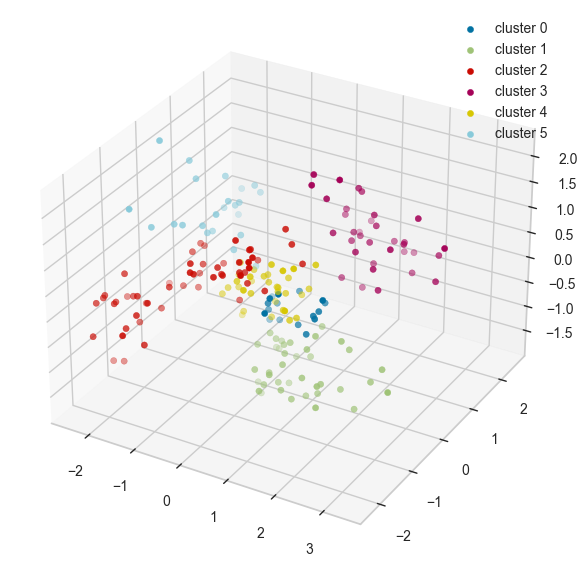

In [33]:
# plot clusters
fig = plt.figure()
ax = Axes3D(fig)

for cluster_label in np.unique(labels_gmm_pca):
    idx_label = np.where(labels_gmm_pca ==cluster_label)
    pc1 = final_pca_features[idx_label,0]
    pc2 = final_pca_features[idx_label,1]
    pc3 = final_pca_features[idx_label,2]
    ax.scatter(pc1, pc2, pc3, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

In [34]:
df_results.loc[5] =['GMM_after_PCA',  
                     davies_bouldin_score(final_pca_features, labels_gmm_pca), 
                     silhouette_score(final_pca_features, labels_gmm_pca)]
df_results.sort_values(by =['Davies_Bouldin_score', 'Silhouette_score']).reset_index(drop =True)

,Model_name,Davies_Bouldin_score,Silhouette_score
0,K_Means_after_t-SNE2,0.549399,0.607769
1,K_Means after PCA,0.765760,0.442804
2,GMM_after_PCA,0.865678,0.379800
3,K_Means,0.909893,0.379297
4,K_Means_after_t-SNE3,1.015789,0.301370
5,GMM,1.814528,0.143873


* We don't see any improvement in any scores. The K-means model with using the 2D tsne_features remains the best model so far.

In [35]:
# Creating and fiting the a Gaussian mixed model with tsne_features_2
gmm_model_tsn2 = GaussianMixture(n_components=6).fit(tsne_features_2)
labels_gmm_tsn2 = gmm_model_tsn2.predict(tsne_features_2)
np.unique(labels_gmm_tsn2)

array([0, 1, 2, 3, 4, 5], dtype=int64)

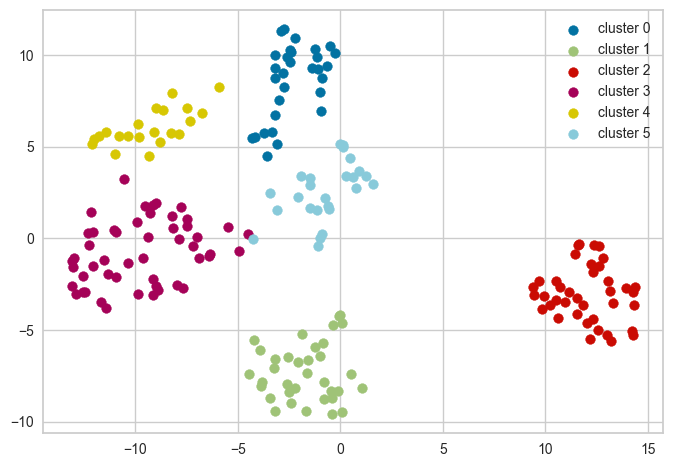

In [36]:
# Scatter plot, coloring by variety_numbers
for cluster_label in np.unique(labels_gmm_tsn2):
    idx_label = np.where(labels_gmm_tsn2==cluster_label)
    pc1 = tsne_features_2[idx_label,0]
    pc2 = tsne_features_2[idx_label,1]
    plt.scatter(pc1, pc2, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

In [37]:
df_results.loc[6] =['GMM_after_t-SNE2',  
                     davies_bouldin_score(tsne_features_2, labels_gmm_tsn2), 
                     silhouette_score(tsne_features_2, labels_gmm_tsn2)]
df_results.sort_values(by =['Davies_Bouldin_score', 'Silhouette_score']).reset_index(drop =True)

,Model_name,Davies_Bouldin_score,Silhouette_score
0,K_Means_after_t-SNE2,0.549399,0.607769
1,GMM_after_t-SNE2,0.552275,0.603194
2,K_Means after PCA,0.765760,0.442804
3,GMM_after_PCA,0.865678,0.379800
4,K_Means,0.909893,0.379297
5,K_Means_after_t-SNE3,1.015789,0.301370
6,GMM,1.814528,0.143873


* The K-means model with using the 2D tsne_features remains the best model so far.

In [38]:
# Creating and fiting the a Gaussian mixed model with tsne_features_3
gmm_model_tsn3 = GaussianMixture(n_components=6).fit(tsne_features_3)
labels_gmm_tsn3 = gmm_model_tsn3.predict(tsne_features_3)
np.unique(labels_gmm_tsn3)

array([0, 1, 2, 3, 4, 5], dtype=int64)

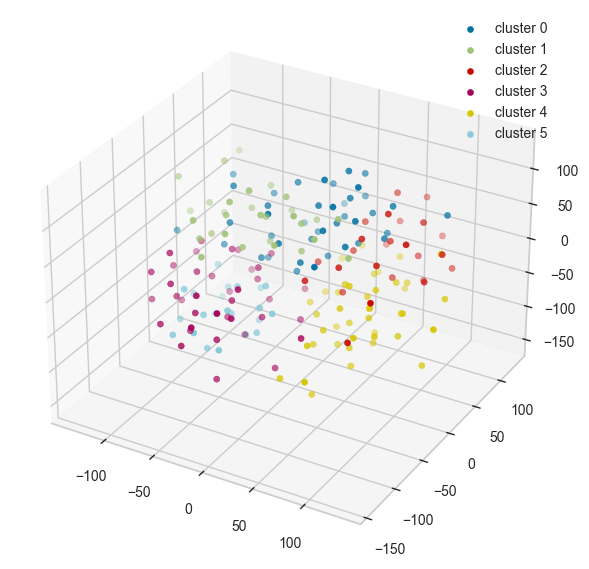

In [39]:
# plot clusters
fig = plt.figure()
ax = Axes3D(fig)

# Select the tsne features
for cluster_label in np.unique(labels_gmm_tsn3):
    idx_label = np.where(labels_gmm_tsn3==cluster_label)
    cp1 = tsne_features_3[idx_label,0]
    cp2 = tsne_features_3[idx_label,1]
    cp3 = tsne_features_3[idx_label,2]
    ax.scatter(cp1, cp2, cp3, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

In [40]:
df_results.loc[7] =['GMM_after_t-SNE3',  
                     davies_bouldin_score(tsne_features_3, labels_gmm_tsn3), 
                     silhouette_score(tsne_features_3, labels_gmm_tsn3)]
df_results.sort_values(by =['Davies_Bouldin_score', 'Silhouette_score']).reset_index(drop =True)

,Model_name,Davies_Bouldin_score,Silhouette_score
0,K_Means_after_t-SNE2,0.549399,0.607769
1,GMM_after_t-SNE2,0.552275,0.603194
2,K_Means after PCA,0.765760,0.442804
3,GMM_after_PCA,0.865678,0.379800
4,K_Means,0.909893,0.379297
5,K_Means_after_t-SNE3,1.015789,0.301370
6,GMM_after_t-SNE3,1.033527,0.286093
7,GMM,1.814528,0.143873


* The best score so far was obtained by K_Means_after_t-SNE2, closely followed by  the Gaussian mixed model using the 2D tsne_features.

# 8. Hierarchical clustering - AHC

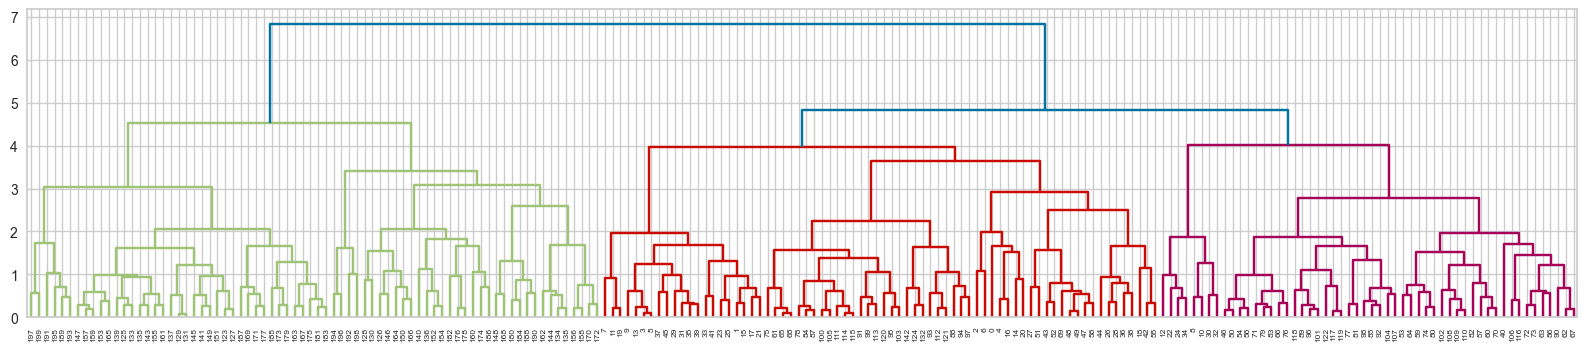

In [41]:
# Calculate the linkage: mergings
mergings = linkage(feautures_scaled, method='complete')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize =(20,4))
dendrogram(mergings,
           labels=df_custumers.index,
           leaf_rotation=90,
           leaf_font_size=6)
plt.show()

In [42]:
labels_AHC = fcluster(mergings, 3.8, criterion ='distance')
np.unique(labels_AHC)

array([1, 2, 3, 4, 5, 6], dtype=int32)

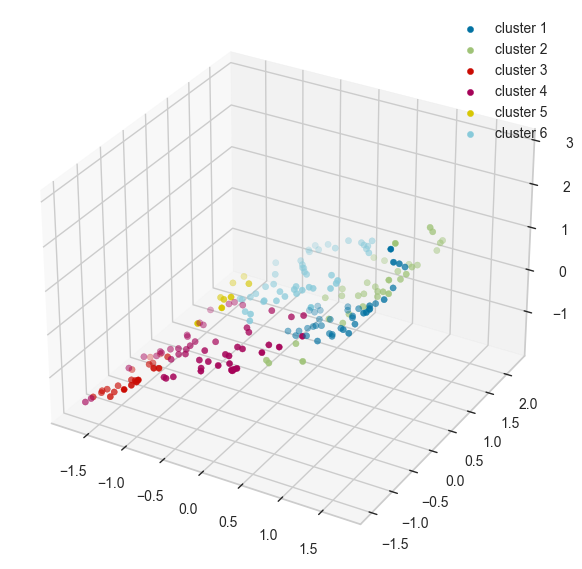

In [43]:
# plot clusters
fig = plt.figure()
ax = Axes3D(fig)

# Select the tsne features
for cluster_label in np.unique(labels_AHC):
    idx_label = np.where(labels_AHC==cluster_label)
    cp1 = feautures_scaled[idx_label,0]
    cp2 = feautures_scaled[idx_label,1]
    cp3 = feautures_scaled[idx_label,2]
    ax.scatter(cp1, cp2, cp3, label=f"cluster {cluster_label}")

plt.legend()
plt.show()

In [44]:
df_results.loc[8] =['AHC',  
                     davies_bouldin_score(feautures_scaled, labels_AHC), 
                     silhouette_score(feautures_scaled, labels_AHC)]
df_results.sort_values(by =['Davies_Bouldin_score', 'Silhouette_score']).reset_index(drop =True)

,Model_name,Davies_Bouldin_score,Silhouette_score
0,K_Means_after_t-SNE2,0.549399,0.607769
1,GMM_after_t-SNE2,0.552275,0.603194
2,K_Means after PCA,0.765760,0.442804
3,GMM_after_PCA,0.865678,0.379800
4,K_Means,0.909893,0.379297
5,AHC,0.988769,0.341313
6,K_Means_after_t-SNE3,1.015789,0.301370
7,GMM_after_t-SNE3,1.033527,0.286093
8,GMM,1.814528,0.143873


**The best score was obtained by K_Means_after_t-SNE2  with the lower Davies_Bouldin_score and the higher Silhouette_score,  closely followed by  the Gaussian mixed model using the 2D tsne_features.**